In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve, auc

In [ ]:
# Define Naïve Bayes class
class NaiveBayes:
    def __init__(self):
        self.classes = None
        self.class_priors = None
        self.means = None
        self.variances = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = {}
        self.means = {}
        self.variances = {}

        for c in self.classes:
            X_c = X[y == c]
            self.class_priors[c] = len(X_c) / len(y)
            self.means[c] = np.mean(X_c, axis=0)
            self.variances[c] = np.var(X_c, axis=0) + 1e-9  # Avoid zero variance

    def _gaussian_pdf(self, x, mean, var):
        epsilon = 1e-9  # Small value to prevent division by zero
        var = np.maximum(var, epsilon)  # Ensure variance is not too small
        exponent = np.exp(-((x - mean) ** 2) / (2 * var))
        pdf = (1 / np.sqrt(2 * np.pi * var)) * exponent
        return np.maximum(pdf, epsilon)  # Ensure no zero values

    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = {}
            for c in self.classes:
                prior = np.log(self.class_priors[c])
                likelihoods = np.sum(np.log(self._gaussian_pdf(x, self.means[c], self.variances[c])))
                posteriors[c] = prior + likelihoods
            predictions.append(max(posteriors, key=posteriors.get))
        return np.array(predictions)


In [ ]:
# Define column names
columns = [
    "duration","protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label","difficulty_level"
]

# Load dataset from text file
filename = "KDDTrain+_20Percent.txt"
df = pd.read_csv(filename, names=columns)
df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df.duplicated().sum()
df = df.drop_duplicates()
df.shape

(25192, 43)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [ ]:

# Convert categorical columns using Label Encoding
categorical_cols = ["protocol_type", "service", "flag"]
for col in categorical_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])


# Convert labels to binary (0 for normal, 1 for attack)
df["label"] = df["label"].apply(lambda x: 0 if x == "normal" else 1)
df["duration"] = pd.to_numeric(df["duration"], errors="coerce")
df["dst_host_srv_rerror_rate"] = pd.to_numeric(df["dst_host_srv_rerror_rate"], errors="coerce")
# Avoid chained assignment by using df.loc
df.loc[:, "duration"] = df["duration"].fillna(df["duration"].median())
df.loc[:, "dst_host_srv_rerror_rate"] = df["dst_host_srv_rerror_rate"].fillna(df["dst_host_srv_rerror_rate"].median())





df["label"].value_counts()




,count
label,
0,13449
1,11743


In [ ]:
# Convert dataframe to numpy array
X = df.drop("label", axis=1).values
y = df["label"].values

In [ ]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Naïve Bayes model
nb = NaiveBayes()
nb.fit(X_train, y_train)

# Make predictions
y_pred = nb.predict(X_test)

In [ ]:
# Compute accuracy
# accuracy = np.mean(y_pred == y_test) * 100
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Model Accuracy: {accuracy:.2f}%")

Model Accuracy: 89.18%


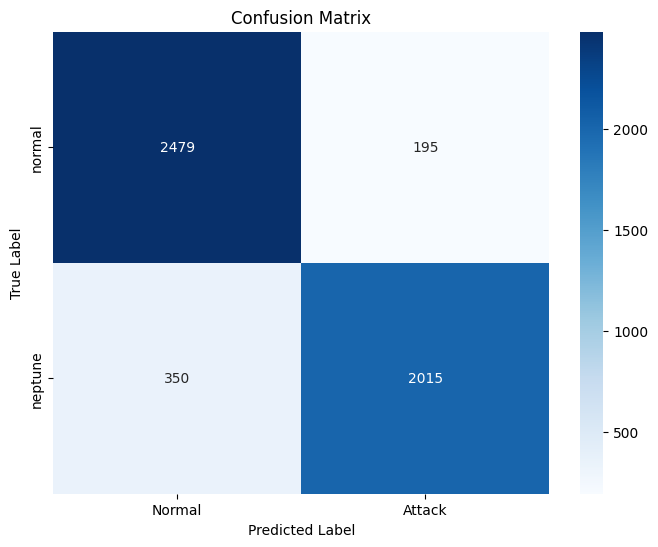

In [ ]:
# Confuséion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Attack"], yticklabels=["normal", "neptune"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




In [ ]:
# Classification Report
report = classification_report(y_test, y_pred, target_names=["normal", "neptune"])
print(report)


              precision    recall  f1-score   support

      normal       0.88      0.93      0.90      2674
     neptune       0.91      0.85      0.88      2365

    accuracy                           0.89      5039
   macro avg       0.89      0.89      0.89      5039
weighted avg       0.89      0.89      0.89      5039



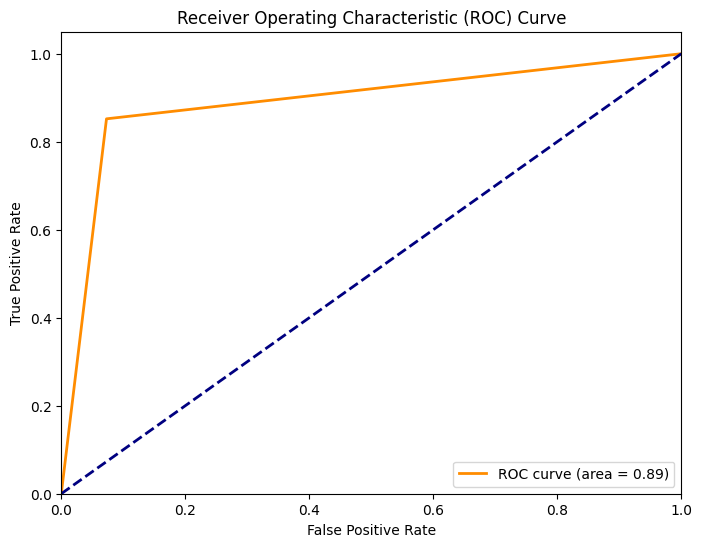

In [ ]:
# ROC Curve
y_probs = nb.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")


F1 Score: 0.88
